## Dependencias

In [21]:
import numpy as np
import pandas as pd 

from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans,AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

from varclushi import VarClusHi
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
cf.go_offline() 
pd.set_option('display.max_columns', None)

## Cargar datos

In [114]:
data = pd.read_csv('data.csv')
data.shape
data = data.loc[data['INAUGURACI'].astype(int)!=0].reset_index(drop=True)

In [115]:
data.head(3)

,N°,DELEGACION,MERCADO,NUM_OFIC,NUM_LOCALE,Coord_Y,Coord_X,DIRECCION,COLONIA,TIPO,SUPERF_M2,INAUGURACI,ANTIGÜEDA,VOCACIÓN,DETALLE,FORMA,NIVELES,TAMAÑO1,PROTEGIDO,COORGEOG_X,COORGEOG_Y
0,18.0,AZCAPOTZALCO,AZCAPOTZALCO,35.0,546.0,2.154268e+06,480539.52674,AV. AZCAPOTZALCO ENTRE ESPERANZA Y RAYON,AZCAPOTZALCO,TRADICIONAL,9346.0,1957.0,63.0,N/D,N/D,CUADRO,1,MEDIANO,SI,-99.185439,19.482872
1,20.0,AZCAPOTZALCO,CLAVERIA,46.0,98.0,2.152290e+06,480987.33324,IRAPUATO Y CLAVERIA S/N,CLAVERIA,TRADICIONAL,2063.0,1947.0,73.0,N/D,N/D,CUADRO,1,CHICO,NO,-99.181152,19.465003
2,17.0,AZCAPOTZALCO,ARENAL,125.0,198.0,2.152428e+06,484181.95416,ALAMO Y CALLE 6 ENTRE OLIVO Y CALLE 6,ARENAL,TRADICIONAL,3129.0,1963.0,57.0,N/D,N/D,RECTANGULO,1,CHICO,SI,-99.150715,19.466271


In [116]:
um = ['N°','MERCADO']
varc = ['NUM_LOCALE','SUPERF_M2','ANTIGÜEDA','NIVELES','COORGEOG_Y','COORGEOG_X']
vard = ['DELEGACION','TIPO','PROTEGIDO','FORMA']

In [117]:
data = data[um+varc+vard]

In [118]:
data.head()

,N°,MERCADO,NUM_LOCALE,SUPERF_M2,ANTIGÜEDA,NIVELES,COORGEOG_Y,COORGEOG_X,DELEGACION,TIPO,PROTEGIDO,FORMA
0,18.0,AZCAPOTZALCO,546.0,9346.0,63.0,1,19.482872,-99.185439,AZCAPOTZALCO,TRADICIONAL,SI,CUADRO
1,20.0,CLAVERIA,98.0,2063.0,73.0,1,19.465003,-99.181152,AZCAPOTZALCO,TRADICIONAL,NO,CUADRO
2,17.0,ARENAL,198.0,3129.0,57.0,1,19.466271,-99.150715,AZCAPOTZALCO,TRADICIONAL,SI,RECTANGULO
3,29.0,PROHOGAR,641.0,7167.0,57.0,1,19.475848,-99.153559,AZCAPOTZALCO,TRADICIONAL,NO,CUADRO
4,33.0,SANTA LUCIA,150.0,3116.0,56.0,1,19.476417,-99.196399,AZCAPOTZALCO,TRADICIONAL,NO,CUADRO


In [119]:
data.columns = ['id','nombre','c_num_locales','c_sup','c_antiguedad','c_niveles',
'c_lat','c_lon','d_delegacion','d_tipo','d_protegido','d_forma']
varc = [v for v in data.columns if v[0]=='c']
vard = [v for v in data.columns if v[0]=='d']
len(varc),len(vard)

(6, 4)

In [120]:
for v in varc:
    data[v] = pd.to_numeric(data[v],errors='coerce')

In [121]:
for v in vard:
    data[v] = data[v].fillna('MISSING')
    display(data[v].value_counts())

d_delegacion
GUSTAVO A. MADERO      48
VENUSTIANO CARRANZA    42
CUAUHTÉMOC             39
COYOACÁN               22
IZTAPALAPA             20
TLALPAN                20
MIGUEL HIDALGO         19
AZCAPOTZALCO           19
TLÁHUAC                18
ÁLVARO OBREGÓN         16
BENITO JUÁREZ          16
IZTACALCO              16
XOCHIMILCO             11
MILPA ALTA              8
MAGDALENA CONTRERAS     5
CUAJIMALPA              5
Name: count, dtype: int64

d_tipo
TRADICIONAL                  271
ESPECIALIZADO                 44
TURISTICO Y ESPECIALIZADO      7
TRADICIONAL Y TURISTICO        2
Name: count, dtype: int64

d_protegido
NO    282
SI     42
Name: count, dtype: int64

d_forma
CUADRO         155
RECTANGULO     136
IRREGULAR       28
CIRCULO          4
RECTANGULAR      1
Name: count, dtype: int64

In [122]:
data['d_forma'].replace({'RECTANGULAR':'RECTANGULO'},inplace=True)

## Análisis exploratorio de datos

### Ausentes

In [123]:
data[varc].isnull().sum()

c_num_locales    0
c_sup            0
c_antiguedad     0
c_niveles        0
c_lat            0
c_lon            0
dtype: int64

### Multicolinealidad

In [124]:
vc = VarClusHi(data[varc],feat_list=varc).varclus()

In [125]:
vc.rsquare.sort_values(by=['Cluster','RS_Ratio'])

,Cluster,Variable,RS_Own,RS_NC,RS_Ratio
1,0,c_sup,0.920672,0.079732,0.086201
0,0,c_num_locales,0.920672,0.081692,0.086385
3,1,c_lat,0.650826,0.045628,0.365868
2,1,c_antiguedad,0.650826,0.069754,0.375357
4,2,c_niveles,0.562517,0.011263,0.442466
5,2,c_lon,0.562517,0.036439,0.454027


In [126]:
mc = ['c_num_locales','c_lat','c_lon','c_antiguedad','c_niveles']

### Univariado

/home/jose/entornos/tse/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning:

The figure layout has changed to tight



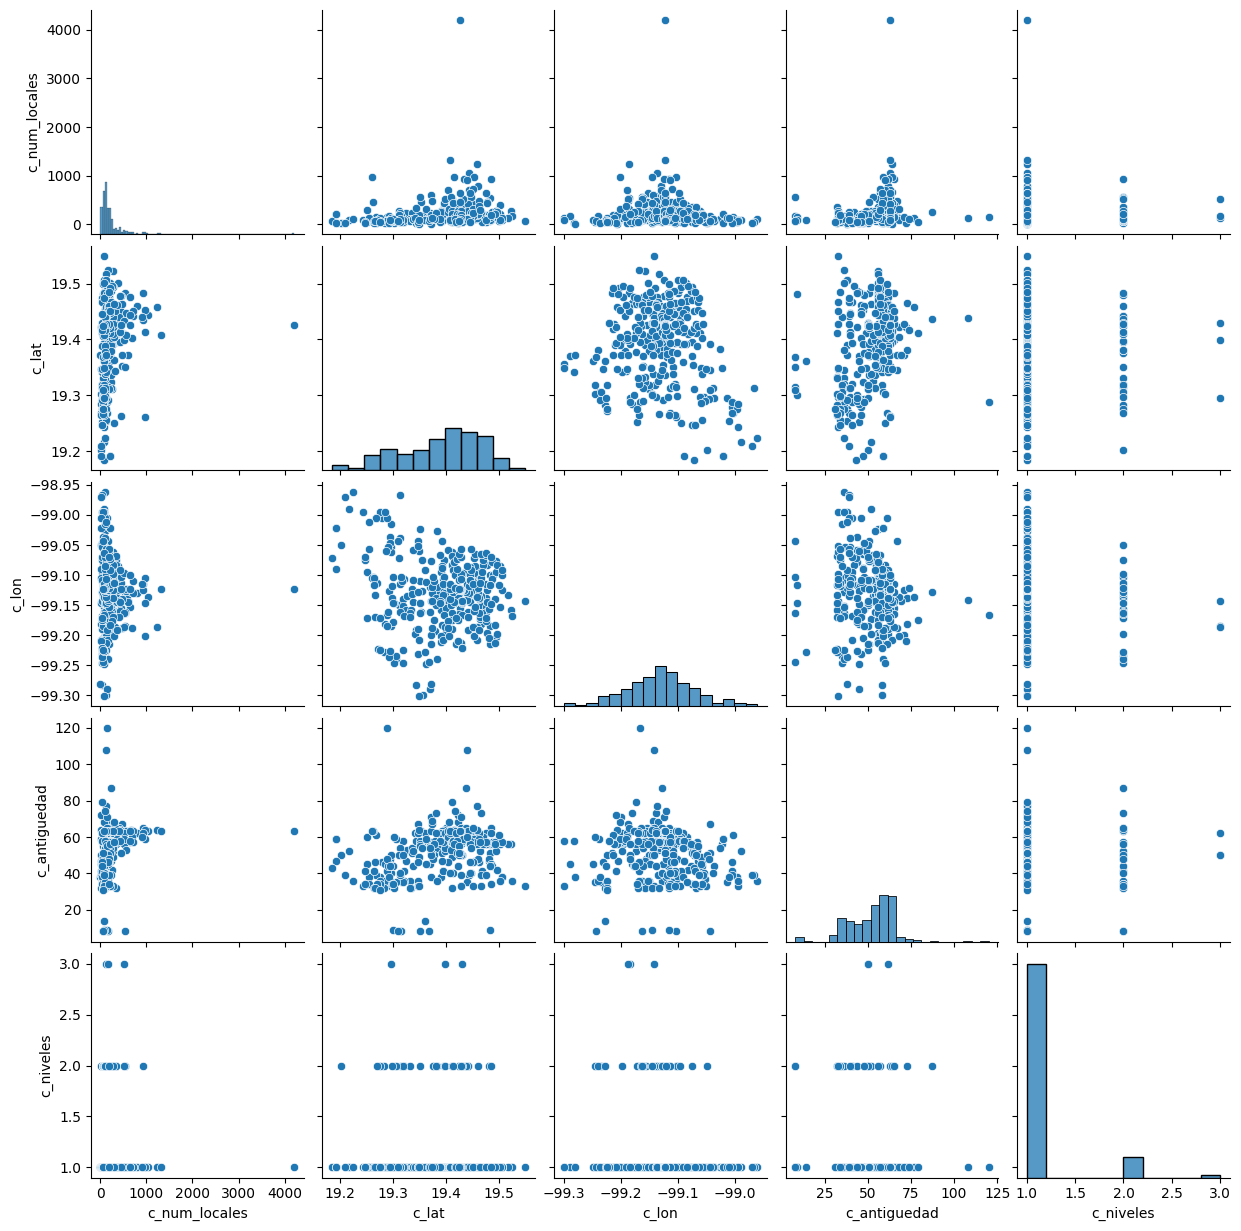

In [127]:
sns.pairplot(data[mc])

## Transformación de espacios

### Natural $\mathcal{X} $ 

In [128]:
X = data[mc].copy()

### Híper-caja $\mathcal{X}_{[0,1]}$

In [129]:
sc = MinMaxScaler()
X01 = pd.DataFrame(sc.fit_transform(X),columns=X.columns)

### PCA $\mathcal{X}_{p} $ 

In [130]:
pipe = make_pipeline(StandardScaler(),PCA(n_components=3),MinMaxScaler())
Xp = pd.DataFrame(pipe.fit_transform(X),columns=['p1','p2','p3'])
pipe.steps[1][1].explained_variance_ratio_.cumsum()

array([0.31638363, 0.54060535, 0.72525731])

In [131]:
um = ['id','nombre']

In [132]:
X[um] = X01[um] = Xp[um] = data[um]

## Inspección visual de los clusters

In [133]:
Xp.iplot(kind='scatter3d',x='p1',y='p2',z='p3',mode='markers',size=10,color='purple', text='nombre')


## Clustering

### Determinar el número de clusters

In [134]:
sil = []
for k in range(3,10):
    cl = KMeans(n_clusters=k)
    cl.fit(X01[mc])
    sil.append((k,silhouette_score(X01[mc],cl.predict(X01[mc]))))
sil = pd.DataFrame(sil,columns=['k','silhouette']).set_index('k').iplot(kind='scatter',mode='markers+lines',size=10,color='purple')

/home/jose/entornos/tse/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/jose/entornos/tse/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/jose/entornos/tse/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/jose/entornos/tse/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

/home/jose/entornos/tse/lib/python3.10/site-packages/sklearn/cluster/_km

In [135]:
k = 4

### Aglomerativo

In [136]:
agg = AgglomerativeClustering(n_clusters=k)
data['agg'] = X['agg'] = X01['agg'] = Xp['agg'] = pd.Series(agg.fit_predict(X01[mc])).map(lambda x:f'CL{x:02d}')

### K-Medias

In [137]:
kme = KMeans(n_clusters=k)
data['kme'] = X['kme'] = X01['kme'] = Xp['kme'] = pd.Series(kme.fit_predict(X01[mc])).map(lambda x:f'CL{x:02d}')

/home/jose/entornos/tse/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



### Mezcla Gaussiana

In [138]:
gmm = GaussianMixture(n_components=k)
data['gmm'] = X['gmm'] = X01['gmm'] = Xp['gmm'] = pd.Series(gmm.fit_predict(X01[mc])).map(lambda x:f'CL{x:02d}')

In [139]:
data.head()

,id,nombre,c_num_locales,c_sup,c_antiguedad,c_niveles,c_lat,c_lon,d_delegacion,d_tipo,d_protegido,d_forma,agg,kme,gmm
0,18.0,AZCAPOTZALCO,546.0,9346.0,63.0,1,19.482872,-99.185439,AZCAPOTZALCO,TRADICIONAL,SI,CUADRO,CL00,CL01,CL02
1,20.0,CLAVERIA,98.0,2063.0,73.0,1,19.465003,-99.181152,AZCAPOTZALCO,TRADICIONAL,NO,CUADRO,CL00,CL01,CL03
2,17.0,ARENAL,198.0,3129.0,57.0,1,19.466271,-99.150715,AZCAPOTZALCO,TRADICIONAL,SI,RECTANGULO,CL00,CL01,CL03
3,29.0,PROHOGAR,641.0,7167.0,57.0,1,19.475848,-99.153559,AZCAPOTZALCO,TRADICIONAL,NO,CUADRO,CL00,CL01,CL02
4,33.0,SANTA LUCIA,150.0,3116.0,56.0,1,19.476417,-99.196399,AZCAPOTZALCO,TRADICIONAL,NO,CUADRO,CL00,CL01,CL03


In [140]:
pd.DataFrame(map(lambda t:silhouette_score(X01[mc],data[t]),['agg','kme','gmm']),columns=['silhouette'],index=['agg','kme','gmm']).iplot(kind='bar',color='purple')

In [141]:
cl = 'kme'

## Visualización de los clusters

In [142]:
Xp.iplot(kind='scatter3d',x='p1',y='p2',z='p3',mode='markers',size=10,categories=cl, text='nombre')

## Perfilamiento

kme
CL01    170
CL00     73
CL02     51
CL03     30
Name: count, dtype: int64

<Axes: ylabel='count'>

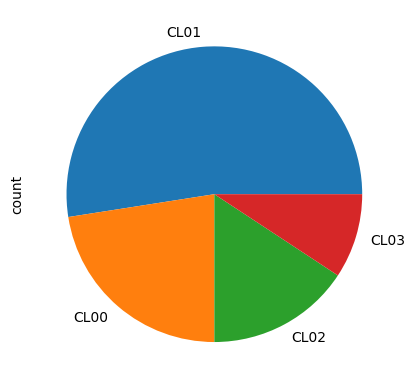

In [143]:
display(data[cl].value_counts())
data[cl].value_counts().plot(kind='pie')

### Continuo

In [144]:
display(data.groupby(cl)[mc].mean())
data[mc].mean().to_frame('mean').T

,c_num_locales,c_lat,c_lon,c_antiguedad,c_niveles
kme,,,,,
CL00,143.931507,19.348829,-99.188467,52.547945,1.000000
CL01,283.582353,19.444105,-99.124101,55.364706,1.000000
CL02,118.137255,19.278269,-99.052664,42.764706,1.019608
CL03,233.166667,19.379761,-99.155394,46.866667,2.100000


,c_num_locales,c_lat,c_lon,c_antiguedad,c_niveles
mean,221.407407,19.390577,-99.130256,51.959877,1.104938


In [145]:
data[data[cl]=='CL03'].sample(3)

,id,nombre,c_num_locales,c_sup,c_antiguedad,c_niveles,c_lat,c_lon,d_delegacion,d_tipo,d_protegido,d_forma,agg,kme,gmm
121,196.0,SAN JOSE ACULCO,121.0,6693.0,48.0,2,19.374915,-99.102705,IZTAPALAPA,TRADICIONAL,NO,CIRCULO,CL01,CL03,CL01
38,62.0,EL VERDE,176.0,2512.0,8.0,2,19.314664,-99.103919,COYOACÁN,TRADICIONAL,NO,CUADRO,CL01,CL03,CL01
225,113.0,SAN LUCAS,254.0,2586.0,64.0,2,19.424944,-99.131098,CUAUHTÉMOC,TRADICIONAL,NO,CUADRO,CL01,CL03,CL01


### Discreto

In [154]:
for v in vard:
    piv = data.pivot_table(index=v,columns=cl,values=mc[0],aggfunc='count',fill_value=0).T
    piv = piv.div(piv.sum(axis=1),axis=0)
    piv.iplot(kind='bar',barmode='stack',size=10)

In [164]:
import folium

colores = dict(zip([f'CL{c:02d}' for c in range(k)],['white', 'black', 'purple', 'pink']))
# Crear objeto Map centrado en las coordenadas promedio
center_lat = data['c_lat'].mean()
center_lon = data['c_lon'].mean()
m = folium.Map(location=[center_lat, center_lon], zoom_start=12)

# Agregar marcadores para cada punto en el dataset, coloreados de acuerdo a la variable cl
for i, row in data.iterrows():
    folium.Marker(location=[row['c_lat'], row['c_lon']], 
                  icon=folium.Icon(color=colores[row[cl]])).add_to(m)

# Mostrar el mapa
display(m)


In [166]:
data[um+varc+vard].to_csv('data_cluster.csv',index=False)